# Crime Activity in Houston

## Download Monthly Crime Files

In [1]:
import requests
import os
os.chdir('/Users/Collier/Dropbox/Skills/Python/Projects/Real_Estate/htx_crime_scraping/months/')

In [20]:
years = [10,11,12,13,14,15,16,17]
months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

dls_base = "http://www.houstontx.gov/police/cs/xls/"
for year in years:
    for mon in months:
        dls = dls_base+str(mon)+str(year)+".xls"
        resp = requests.get(dls)
        save_name = str(mon)+"_"+str(year)+".xls"
        with open(save_name, 'wb') as output:
            output.write(resp.content)

## Import Monthly Crime Files

In [2]:
dir = "/Users/Collier/Dropbox/Skills/Python/Projects/Real_Estate/htx_crime_scraping/months/"
dir_hcad = "/Users/Collier/Downloads/Real_acct_owner (3)/"

In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_colwidth', -1)

In [4]:
import os
os.chdir(dir)
files = [f for f in os.listdir('.') if os.path.isfile(f)]

In [5]:
for idx,file in enumerate(files):
#     print(idx)
    dat = pd.read_excel(dir+file)
    if idx == 0:
        datAll = dat
    datAll = pd.concat([datAll,dat])

WARNING *** file size (2752234) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [6]:
datAll.shape

(959476, 18)

In [7]:
datAll['Offense_count'] = np.where(~np.isnan(datAll['# Of']),datAll['# Of'],np.nan)
datAll['Offense_count'] = np.where(~np.isnan(datAll['# Of Offenses']),datAll['# Of Offenses'],datAll['Offense_count'])
datAll['Offense_count'] = np.where(~np.isnan(datAll['# Offenses']),datAll['# Offenses'],datAll['Offense_count'])
datAll['Offense_count'] = np.where(~np.isnan(datAll['# offenses']),datAll['# offenses'],datAll['Offense_count'])
datAll['Offense_count'] = np.where(~np.isnan(datAll['Offenses']),datAll['Offenses'],datAll['Offense_count'])

In [8]:
datAll['Street_name'] = np.where(~pd.isnull(datAll['Street Name']),datAll['Street Name'],np.nan)
datAll['Street_name'] = np.where(~pd.isnull(datAll['StreetName']),datAll['StreetName'],datAll['Street_name'])

In [9]:
datAll['Block_range'] = np.where(~pd.isnull(datAll['Block Range']),datAll['Block Range'],np.nan)
datAll['Block_range'] = np.where(~pd.isnull(datAll['BlockRange']),datAll['BlockRange'],datAll['Block_range'])

## Download HCAD Dataset

While the monthly crime data from HPD is very detailed, unfortunately it does not contain zip code.  The aggregated geographical area unit is instead beat number.  While this is useful, we are more interested in Zip code.  For that reason we will import another dataset, the 20__ HCAD property value dataset.

## Import HCAD Dataset

In [10]:
dat_hcad = pd.read_table(dir_hcad+"real_acct.txt", sep='\t', encoding = "ISO-8859-1")

/Users/Collier/miniconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,21,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Add headers

We need to bring in the headers for this dataset, which are saved in a different file.

### Create Lookup Keys

To bring zip code back to our crime dataset, we need to create a lookup key on the relative address.  The crime dataset gives us a 'block range' where the crime occurred.  Concatenating this with the street number gives us the block where the crime occurred.  We will create a similarly formatted 'blk_range' column in our HCAD dataset.  This will then be used to bring the zip code from the HCAD dataset into our crime dataset.

In [11]:
# create lookup key in HCAD dataset
dat_hcad['blk_lower'] = dat_hcad['0'] - dat_hcad['0'] % 100
dat_hcad['blk_upper'] = dat_hcad['blk_lower'] + 99
dat_hcad['blk_range'] = dat_hcad['blk_lower'].map(str)+'-'+dat_hcad['blk_upper'].map(str)+' '+dat_hcad['COMMERCE'].map(str)

In [12]:
# create lookup key in crime dataset
datAll['blk_rng'] = datAll['Block_range'].map(str)+' '+datAll['Street_name'].map(str)

In [13]:
#create df from HCAD dataset with just addresses and zips
dat_hcad_1 = dat_hcad['blk_range']
dat_hcad_2 = dat_hcad['77002']
dat_hcad_zip = pd.concat([dat_hcad_1,dat_hcad_2],axis=1)
dat_hcad_zip.shape

(1441705, 2)

In [16]:
dat_hcad_zip.drop_duplicates(subset='blk_range',keep="last",inplace=True)
dat_hcad_zip.columns = ['blk_range','zip']
dat_hcad_zip.shape

(141906, 2)

### Lookup Zip Code

We now lookup the zip code from the HCAD dataset via the block range keys we created in both datasets.  Unfortunately we did have a slight loss in data, about 14%.  This is because the HCAD dataset did not have addresses on the blocks where the crimes took place.

In [17]:
datAll['zip'] = datAll.blk_rng.map(dat_hcad_zip.set_index('blk_range').zip)

In [18]:
datAll['zip'].value_counts(dropna=False)[0]/len(datAll)

0.12574571953858146

In [19]:
# dat_missing_zip = datAll[pd.isnull(datAll['zip'])]

In [20]:
# dat_missing_zip['year'].value_counts(dropna=False)

## Data Cleaning

Below we will make some changes to the data to make it more usable.

### Fixing Dates

Lets fix the dates so that we can do some time series analysis.

In [21]:
from datetime import datetime as dt
datAll['Date'] = pd.to_datetime(datAll['Date'])
datAll = datAll[(datAll['Date']>='2010-01-01') & 
                (datAll['Date']<='2018-01-01')]

In [22]:
datAll['year'] = datAll['Date'].map(lambda x: x.year)
datAll['month'] = datAll['Date'].map(lambda x: x.month)
# datAll['month'] = datAll['Date'].map(lambda x: x.)
# datAll['Year-Mon'] = datAll['Date'].dt.strftime('%b-%Y')

We will also create a half-year column.  This is because the data was gathered in July 2017, which is only have a year. Instead of discarding it and making an annual grouping look artificially low for 2017, we will be able to group by half year intervals

In [23]:
month_bins = [0,6,12]
datAll['month_rng'] = pd.cut(datAll['month'],month_bins)
datAll['half_year'] = np.where(datAll['month_rng']=="(0, 6]","first","second")
datAll['half_year'] = datAll['half_year'].astype(str)

In [24]:
datAll['half_year'].value_counts(dropna=False)

first     504103
second    452692
Name: half_year, dtype: int64

### Violent vs Non-Violent

Lets also divide the crime types into 'violent' and 'non-violent'

In [25]:
# clean up whitespace
datAll['Offense Type'] = datAll['Offense Type'].str.strip()
# clean up spelling
datAll['Offense Type'] = np.where(datAll['Offense Type']=="AutoTheft",'Auto Theft',datAll['Offense Type'])

In [26]:
datAll['violence_type'] = np.where(datAll['Offense Type'].isin(["Theft",
                                                                "Burglary",
                                                                "Auto Theft"]),"non-violent",np.nan)
datAll['violence_type'] = np.where(datAll['Offense Type'].isin(["Aggravated Assault",
                                                                "Robbery",
                                                                "Rape",
                                                                "Murder"]),"violent",datAll['violence_type'])

## Aggregation & Visualization

Lets create some data aggregations on the crime data which we can then visualize.

### Crimes by Month & Year

In [27]:
crimes_by_yr_month = pd.DataFrame(datAll.groupby([datAll['year'],datAll['month']])
#                                   .size())
                               .agg({'Offense_count':'sum'}))

In [28]:
crimes_by_yr_month.reset_index(inplace=True)
crimes_by_yr_month.columns = ["year","month","crime_count"]

In [29]:
crimes_by_yr_month.head()

,year,month,crime_count
0,2010,1,11323.0
1,2010,2,9829.0
2,2010,3,12197.0
3,2010,4,23098.0
4,2010,5,12843.0


In [30]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)

ax1.plot(crimes_by_yr_month['year'], crimes_by_yr_month['crime_count'], label=1)

/Users/Collier/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/Collier/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


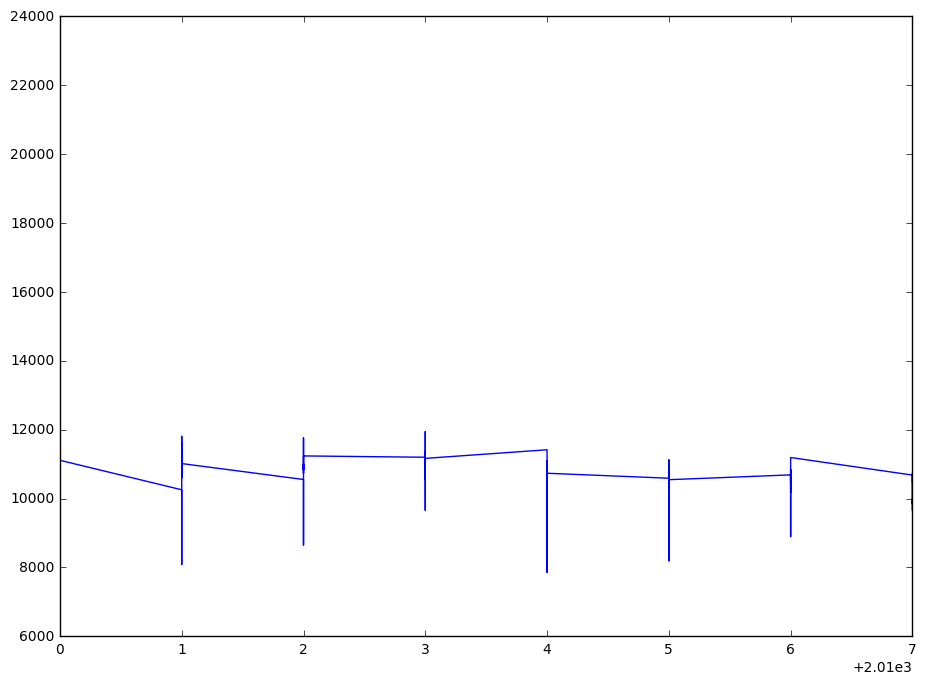

In [31]:
plt.show()

### Crimes by Type

In [32]:
crimes_by_type = pd.DataFrame(datAll.groupby(datAll['Offense Type'])
                              .agg({'Offense_count':'sum'}))

In [33]:
crimes_by_type.reset_index(inplace=True)

In [34]:
crimes_by_type.sort_values("Offense_count",ascending=False)

,Offense Type,Offense_count
6,Theft,528567.0
2,Burglary,175400.0
1,Auto Theft,99381.0
0,Aggravated Assault,87094.0
5,Robbery,72683.0
4,Rape,6298.0
3,Murder,1864.0


### Crimes by Month & Type

In [35]:
crimes_by_yr_month_type = pd.DataFrame(datAll.groupby([
    datAll['year'],datAll['month'],datAll['Offense Type']]).agg({'Offense_count':'sum'}))

In [36]:
crimes_by_yr_month_type.reset_index(inplace=True)

In [37]:
# crimes_by_yr_month_type

### Crimes by Zip, Month & Type

In [38]:
crimes_by_yr_month_zip_type = pd.DataFrame(datAll.groupby([
    datAll['year'],datAll['month'],datAll['zip'],datAll['Offense Type']]).agg({'Offense_count':'sum'}))

In [39]:
# crimes_by_yr_month_zip_type

### Rolling Average Crimes by Zip

Below, we take a 3 year (6 half-year periods) rolling average of violent & non-violent crimes by zip code.

In [40]:
# (datAll.groupby([datAll['year'],datAll['zip'],datAll['violence_type']])['Offense_count']
#      .fillna(0)
#      .rolling(3)
#      .mean())

In [41]:
# (datAll.groupby([datAll['year']])['Offense_count']
#      .fillna(0)
#      .rolling(3)
#      .mean())

In [42]:
# temp = (df.groupby('fruit')['amount']
#     .apply(lambda x: x.reindex(dates)  # fill in the missing dates for each group)
#                       .fillna(0)   # fill each missing group with 0
#                       .rolling(3)
#                       .sum()) # do a rolling sum
#     .reset_index()
#     .rename(columns={'amount': 'sum_of_3_days', 
#                      'level_1': 'date'}))

In [43]:
pivoted_df = pd.pivot_table(datAll, 
                            index=['zip','year','half_year'], 
                            columns='violence_type', 
                            values='Offense_count',
                            aggfunc="sum")

In [44]:
average_crimes = pd.DataFrame(pivoted_df.rolling(window=6).mean().stack())
average_crimes.reset_index(inplace=True)

Finally, lets subset out for the first half of 2017 only.

In [45]:
average_crimes_current = average_crimes[(average_crimes['year']==2017) &
                                               (average_crimes['half_year']=="first")]

In [46]:
average_crimes_current.head()

,zip,year,half_year,violence_type,0
20,77003,2017,first,non-violent,5.333333
35,77004,2017,first,non-violent,6.000000
50,77006,2017,first,non-violent,10.500000
66,77007,2017,first,non-violent,21.166667
81,77008,2017,first,non-violent,13.000000


#### Export

Now we will export this dataset as it will be used as part of another analysis.   Link>>>>>>

In [50]:
dir = '/Users/Collier/Dropbox/Skills/\
Python/Projects/Real_Estate/htx_crime_scraping/'

In [53]:
os.chdir(dir)
average_crimes_current.to_csv("rolling_crime_avg_by_zip.csv")